<a href="https://colab.research.google.com/github/saqlainkazi690/Projects/blob/main/VGG19_Mura_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d cjinny/mura-v11

Dataset URL: https://www.kaggle.com/datasets/cjinny/mura-v11
License(s): unknown
100% 3.14G/3.14G [02:04<00:00, 38.7MB/s]
100% 3.14G/3.14G [02:04<00:00, 27.0MB/s]


In [3]:
from zipfile import ZipFile
dataset = '/content/mura-v11.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [4]:
!pip install keras-preprocessing
!pip install tensorflow-addons
!pip install keras-adabound

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for keras-adabound: filename=keras_adabound-0.6.0-py3-none-any.whl size=6589 sha256=cb1159d096ecb2f1b5d6ec692bb2f4e99d128675eac9c10e66260568c8231fe9
  Stored in directory: /root/.cache/pip/wheels/c7/0c/82/026bbf0810e0ac6d6b6686fef3891d052534ecb440a0c28c19
Successfully built keras-adabound


In [5]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from enum import Enum
import cv2
from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
import gc
from tensorflow.keras.utils import to_categorical
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam
from keras_adabound import AdaBound
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Input, Conv2D,BatchNormalization
from tensorflow.keras.layers import Activation,SpatialDropout2D,AvgPool2D
from tensorflow.keras.layers import MaxPool2D,Dropout,GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D,Flatten,Dropout,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow_addons.metrics import CohenKappa
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import DenseNet121,DenseNet169,DenseNet201
from tensorflow.keras.models import load_model
from numpy import dstack
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
seed = 3352024
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

In [7]:
def load_path(path):

    '''
    load MURA dataset
    '''
    dataset = []
    for body in os.listdir(path):
        body_part = body
        path_p = path+'/'+str(body)
        for id_p in os.listdir(path_p):
            patient_id = id_p
            path_id = path_p+'/'+str(id_p)
            for lab in os.listdir(path_id):
                if lab.split('_')[-1]=='positive':
                    label = 1
                elif lab.split('_')[-1]=='negative':
                    label= 0
                path_l = path_id+'/'+str(lab)
                for img in os.listdir(path_l):
                    img_path = path_l + '/' + str(img)
                    dataset.append(
                        {
                            'body_part': body_part,
                            'patient_id': patient_id,
                            'label': label,
                            'img_path': img_path
                        }
                    )
    return dataset

In [8]:
path = '/content/MURA-v1.1/train'
os.listdir(path)

['XR_SHOULDER',
 'XR_ELBOW',
 'XR_FINGER',
 'XR_WRIST',
 'XR_FOREARM',
 'XR_HAND',
 'XR_HUMERUS']

In [9]:
dataset = load_path(path)
df_train = pd.DataFrame(dataset)
df_train.head()

,body_part,patient_id,label,img_path
0,XR_SHOULDER,patient01657,0,/content/MURA-v1.1/train/XR_SHOULDER/patient01...
1,XR_SHOULDER,patient01657,0,/content/MURA-v1.1/train/XR_SHOULDER/patient01...
2,XR_SHOULDER,patient01657,0,/content/MURA-v1.1/train/XR_SHOULDER/patient01...
3,XR_SHOULDER,patient02462,0,/content/MURA-v1.1/train/XR_SHOULDER/patient02...
4,XR_SHOULDER,patient02303,0,/content/MURA-v1.1/train/XR_SHOULDER/patient02...


In [10]:
dataset_test = load_path(path = '/content/MURA-v1.1/valid')
df_test = pd.DataFrame(dataset_test)
df_test.head()

,body_part,patient_id,label,img_path
0,XR_SHOULDER,patient11586,1,/content/MURA-v1.1/valid/XR_SHOULDER/patient11...
1,XR_SHOULDER,patient11586,1,/content/MURA-v1.1/valid/XR_SHOULDER/patient11...
2,XR_SHOULDER,patient11795,0,/content/MURA-v1.1/valid/XR_SHOULDER/patient11...
3,XR_SHOULDER,patient11795,0,/content/MURA-v1.1/valid/XR_SHOULDER/patient11...
4,XR_SHOULDER,patient11795,0,/content/MURA-v1.1/valid/XR_SHOULDER/patient11...


In [11]:
train_image_paths_csv = "/content/MURA-v1.1/train_image_paths.csv"

In [12]:
train_images_paths = pd.read_csv(os.path.join(path,train_image_paths_csv),dtype=str,header=None)
train_images_paths.columns = ['image_path']

In [13]:
train_images_paths['label'] = train_images_paths['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
train_images_paths['category']  = train_images_paths['image_path'].apply(lambda x: x.split('/')[2])
train_images_paths['patientId']  = train_images_paths['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))
train_images_paths.head()

,image_path,label,category,patientId
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002


In [14]:
valid_image_paths_csv = "/content/MURA-v1.1/valid_image_paths.csv"
valid_data_paths = pd.read_csv(os.path.join(path,valid_image_paths_csv),dtype=str,header=None)
valid_data_paths.columns = ['image_path']

In [15]:
valid_data_paths['label'] = valid_data_paths['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
valid_data_paths['category']  = valid_data_paths['image_path'].apply(lambda x: x.split('/')[2])
valid_data_paths['dir'] =  valid_data_paths['image_path'].apply(lambda x: x.split('/')[1])
valid_data_paths['patientId']  = valid_data_paths['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))
valid_data_paths.head()

,image_path,label,category,dir,patientId
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,positive,XR_WRIST,valid,11186


In [16]:
train_images_paths['label_index']= train_images_paths.label

In [17]:
train_images_paths.label_index.replace('positive', 1, inplace=True)
train_images_paths.label_index.replace('negative', 0, inplace=True)
train_images_paths.head(3)

,image_path,label,category,patientId,label_index
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,1


In [18]:
valid_data_paths['label_index']= valid_data_paths.label
valid_data_paths.label_index.replace('positive', 1, inplace=True)
valid_data_paths.label_index.replace('negative', 0, inplace=True)
valid_data_paths.head(3)

,image_path,label,category,dir,patientId,label_index
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185,1


In [19]:
im_size = 256

In [20]:
def random_rotation_flip(image,size = 256):
    if random.randint(0,1):
        image = cv2.flip(image,1) # 1-->horizontal flip 0-->Vertical flip -1-->Horizontal and vertical

    if random.randint(0,1):
            angle = random.randint(-30,30)
            M = cv2.getRotationMatrix2D((size/2,size/2),angle,1)
            #The third parameter: the size of the transformed image
            image = cv2.warpAffine(image,M,(size,size))
    return image

In [21]:
def image_loader(Path, size = 224):
    Images = []
    for path in tqdm(Path):
        try:
            image = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image,(size,size))
            image = random_rotation_flip(image,size)
            Images.append(image)
        except Exception as e:
            print(str(e))
    Images = np.asarray(Images).astype('float32')
    mean = np.mean(Images)
    std = np.std(Images)
    Images = (Images - mean) / std

    return Images

In [22]:
X_train = image_loader(train_images_paths['image_path'][:50,],im_size)

100%|██████████| 50/50 [00:00<00:00, 260.80it/s]


In [23]:
y_train = train_images_paths['label']

In [24]:
Y_train = y_train.replace("positive",1)
Y_train = Y_train.replace("negative",0)

In [25]:
X_test = image_loader(valid_data_paths['image_path'][:50,],im_size)

100%|██████████| 50/50 [00:00<00:00, 234.33it/s]


In [26]:
y_test = valid_data_paths['label']

In [27]:
Y_test = y_test.replace("positive",1)
Y_test = Y_test.replace("negative",0)

In [28]:
train, valid = train_test_split(train_images_paths, test_size=0.2,random_state=seed)

In [29]:
test = valid_data_paths.drop(['dir'], axis=1)

In [30]:
image_generator_settings = dict(
                          rescale = 1. / 255,
                          #samplewise_center = True,
                          #samplewise_std_normalization = True
                          #rotation_range = 5,
                         )
image_generator = ImageDataGenerator(**image_generator_settings)

In [31]:
train_generator = image_generator.flow_from_dataframe(dataframe = train,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = True,class_mode = 'raw', target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest',validate_filenames=False,seed=seed)
valid_generator = image_generator.flow_from_dataframe(dataframe = valid,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = True,class_mode = 'raw',target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest',validate_filenames=True,seed=seed)
test_generator = image_generator.flow_from_dataframe(dataframe = test,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = False,class_mode = 'raw', target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest', validate_filenames=True,seed=seed)

Found 29446 non-validated image filenames.
Found 7362 validated image filenames.
Found 3197 validated image filenames.


In [32]:
CLASSES = 2
input_shape = (im_size,im_size,3)

In [33]:
def metrics():
    return [
        AUC(name="auc"),
        BinaryAccuracy("accuracy"),
        CohenKappa(name="kappa", num_classes=2)
    ]

In [34]:
def plot_history(hs, epochs, metric):
    if metric=='loss':
                label_y = 'Loss'
    elif metric=='accuracy':
               label_y = 'Accuracy'
    elif metric=='auc':
               label_y = 'AUC'
    else : label_y = 'kappa'
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel(label_y)
    plt.legend()
    plt.show()
def print_results(model_name,epochs,hs,model_eval):
    print("Train Loss     : {0:.5f}".format(hs.history['loss'][-1]))
    print("Validation Loss: {0:.5f}".format(hs.history['val_loss'][-1]))
    print("Test Loss      : {0:.5f}".format(model_eval[0]))
    print("---")
    print("Train AUC     : {0:.5f}".format(hs.history['auc'][-1]))
    print("Validation AUC: {0:.5f}".format(hs.history['val_auc'][-1]))
    print("Test AUC      : {0:.5f}".format(model_eval[1]))
    print("---")
    print("Train Accuracy     : {0:.5f}".format(hs.history['accuracy'][-1]))
    print("Validation Accuracy: {0:.5f}".format(hs.history['val_accuracy'][-1]))
    print("Test Accuracy      : {0:.5f}".format(model_eval[2]))
    print("---")
    print("Train Kappa     : {0:.5f}".format(hs.history['kappa'][-1]))
    print("Validation Kappa: {0:.5f}".format(hs.history['kappa'][-1]))
    print("Test Kappa      : {0:.5f}".format(model_eval[3]))
    # Plot train and validation error per epoch.
    plot_history(hs={model_name: hs}, epochs=epochs, metric='loss')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='auc')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='accuracy')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='kappa')

In [35]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect() #garbage collection
    print("...Finished clean up...")

In [36]:
def VGGNET19_builder(
        pooling="max",
        shape=(256, 256, 3),
        trainable_layers_after=None
    ):
    VGGNET19 = VGG19(include_top=False,weights='imagenet',input_shape=shape,pooling=pooling)
    if trainable_layers_after:
        for layer in VGGNET19.layers[:trainable_layers_after]:
            layer.trainable = False
    else:
        VGGNET19.trainable = False
    prediction_layer = Dense(1, activation="sigmoid",name="VGGNET_output_sigmoid")
    model = Sequential(
        layers=[
            VGGNET19,
            prediction_layer
        ],
        name="VGGNET19"
    )
    return model
epochs = 50

80134624/80134624 [==============================] - 2s 0us/step
Epoch 1/15
461/461 [==============================] - 270s 546ms/step - loss: 0.6576 - auc: 0.6114 - accuracy: 0.6074 - kappa: 0.0392 - val_loss: 0.6503 - val_auc: 0.6419 - val_accuracy: 0.6118 - val_kappa: 0.0795
Epoch 2/15
461/461 [==============================] - 282s 611ms/step - loss: 0.6410 - auc: 0.6502 - accuracy: 0.6277 - kappa: 0.1225 - val_loss: 0.6407 - val_auc: 0.6574 - val_accuracy: 0.6304 - val_kappa: 0.1798
Epoch 3/15
461/461 [==============================] - 241s 523ms/step - loss: 0.6331 - auc: 0.6635 - accuracy: 0.6376 - kappa: 0.1660 - val_loss: 0.6342 - val_auc: 0.6676 - val_accuracy: 0.6338 - val_kappa: 0.1681
Epoch 4/15
461/461 [==============================] - 275s 597ms/step - loss: 0.6281 - auc: 0.6713 - accuracy: 0.6427 - kappa: 0.1834 - val_loss: 0.6326 - val_auc: 0.6740 - val_accuracy: 0.6388 - val_kappa: 0.2256
Finished training.
------------------
Model: "VGGNET19"
_______________________

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved /kaggle/working/model_VGGNET19.h5
50/50 [==============================] - 35s 709ms/step - loss: 0.6774 - auc: 0.6449 - accuracy: 0.5555 - kappa: 0.0759
...Finished clean up...
Train Loss     : 0.62814
Validation Loss: 0.63257
Test Loss      : 0.67744
---
Train AUC     : 0.67131
Validation AUC: 0.67398
Test AUC      : 0.64494
---
Train Accuracy     : 0.64270
Validation Accuracy: 0.63882
Test Accuracy      : 0.55552
---
Train Kappa     : 0.18337
Validation Kappa: 0.18337
Test Kappa      : 0.07593


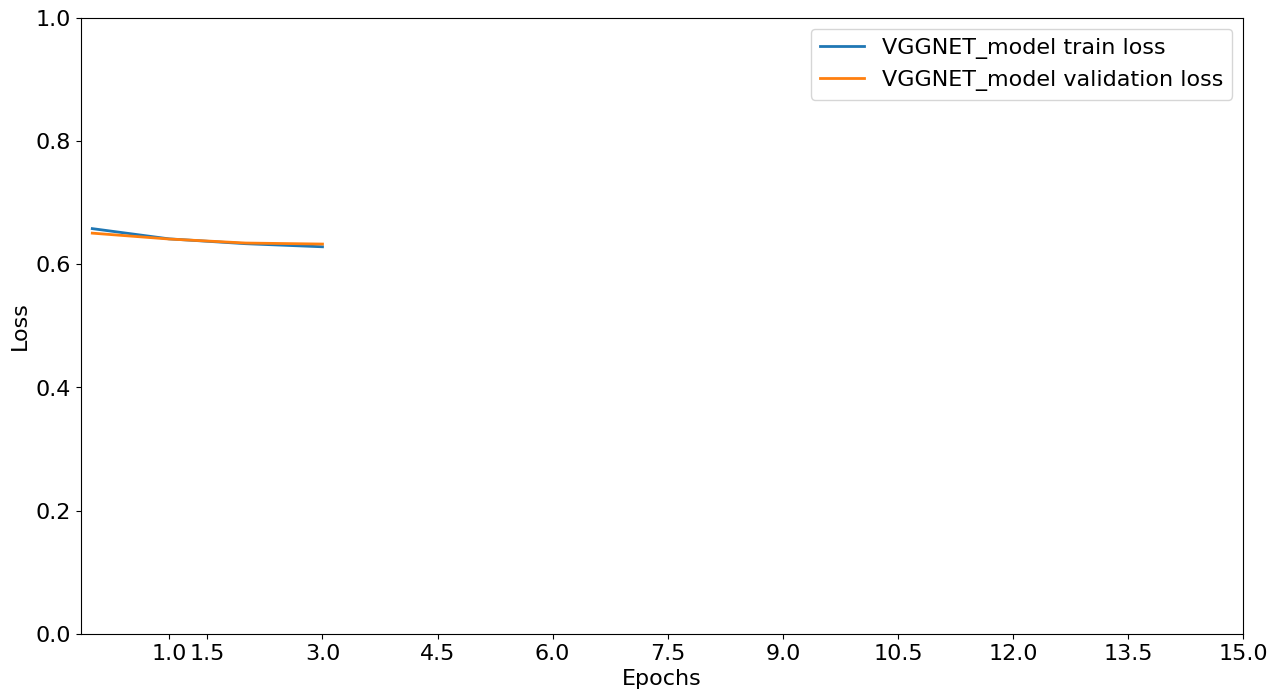

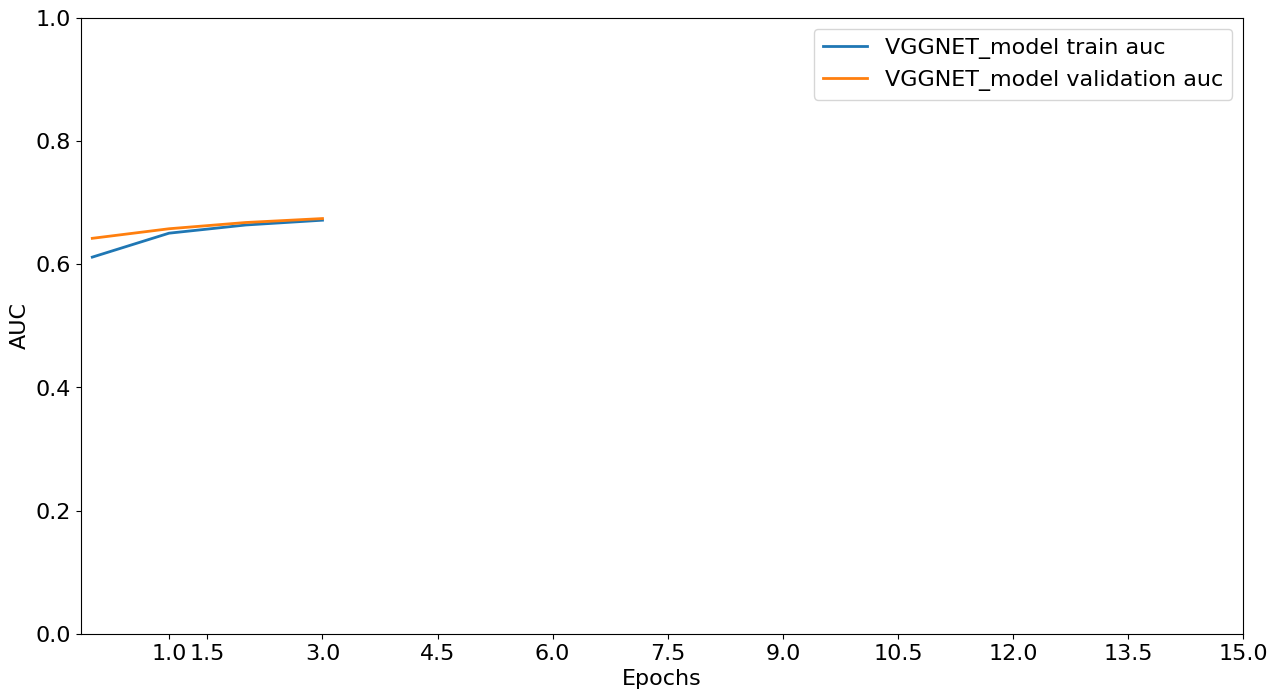

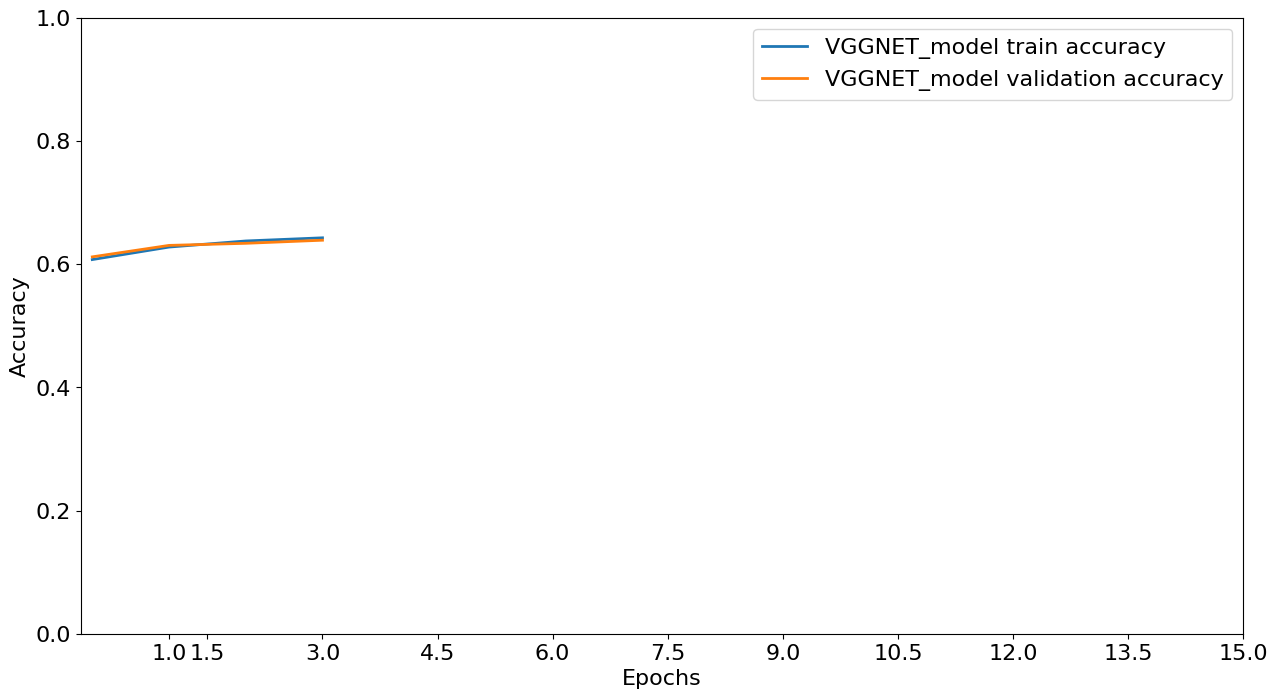

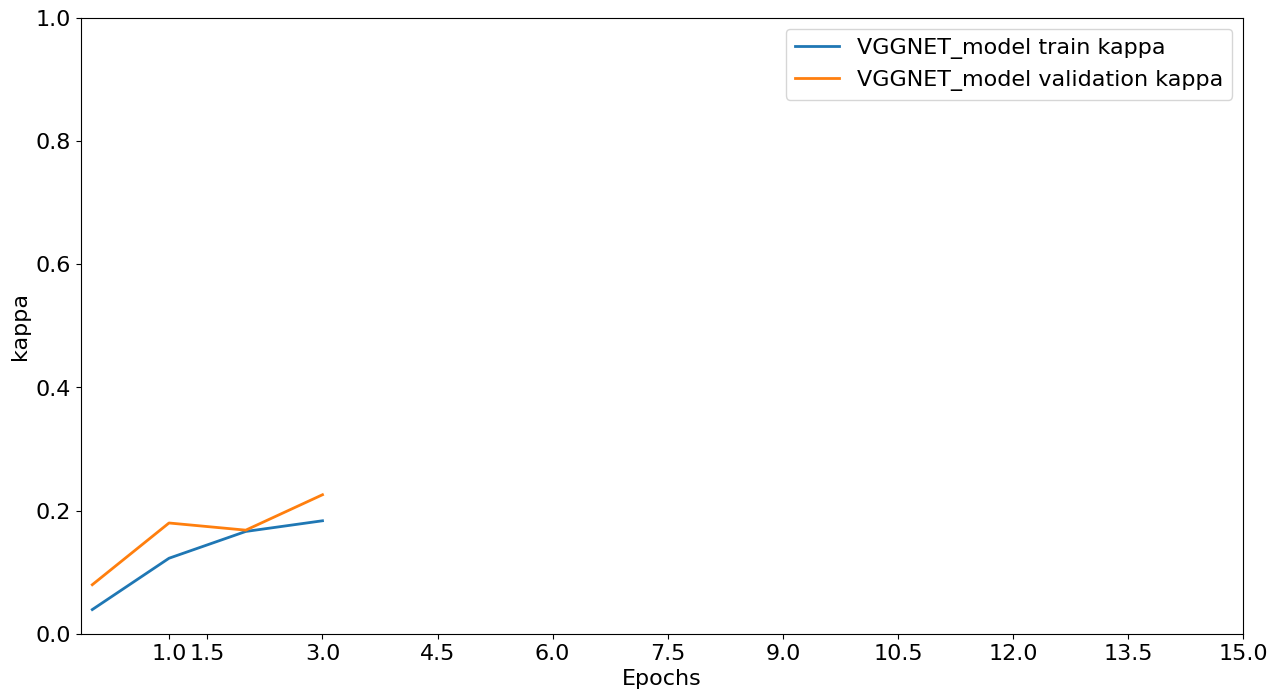

In [37]:
epochs = 15
early_stop = EarlyStopping(monitor="kappa",mode="min", patience=3, restore_best_weights=True)
VGGNET_model19 = VGGNET19_builder(pooling='avg')
VGGNET_model19.compile(optimizer=Adam(), loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
hs = VGGNET_model19.fit(train_generator,validation_data = valid_generator, epochs = epochs,callbacks=[early_stop])
print('Finished training.')
print('------------------')
VGGNET_model19.summary()
filename = '/kaggle/working/model_VGGNET19.h5'
VGGNET_model19.save(filename)
print('>Saved %s' % filename)
VGGNET_model_eval = VGGNET_model19.evaluate(test_generator)
clean_up(model=VGGNET_model19)
print_results(model_name='VGGNET_model',epochs= epochs,hs = hs,model_eval = VGGNET_model_eval)